In [ ]:
# Cuda测试
import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

In [ ]:
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot

#如果网络能在GPU中训练，就使用GPU；否则使用CPU进行训练
device = "cuda:0" if torch.cuda.is_available() else "cpu"

#这个函数包括了两个操作：将图片转换为张量，以及将图片进行归一化处理
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(mean=[0.5], std=[0.5])])

# 构建数据集
path = './data/'  #数据集下载后保存的目录

#下载训练集和测试集
trainData = torchvision.datasets.MNIST(path, train=True, transform=transform, download=True)
testData = torchvision.datasets.MNIST(path, train=False, transform=transform, download=True)

#设定每一个Batch的大小
BATCH_SIZE = 256

#构建数据集和测试集的DataLoader
trainDataLoader = torch.utils.data.DataLoader(dataset=trainData, batch_size=BATCH_SIZE, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(dataset=testData, batch_size=BATCH_SIZE)

In [ ]:
# 构建模型
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = torch.nn.Sequential(
            #The size of the picture is 28x28
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),

            #The size of the picture is 14x14
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),

            #The size of the picture is 7x7
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),

            torch.nn.Flatten(),
            torch.nn.Linear(in_features=7 * 7 * 64, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=128, out_features=10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, input):
        output = self.model(input)
        return output

In [ ]:
# 创建模型实例
net = Net()
print(net.to(device))

In [ ]:
# 创建损失函数和优化器
lossF = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

In [ ]:
# 训练模型
EPOCHS = 10
history = {'Test Loss': [], 'Test Accuracy': []}
for epoch in range(1, EPOCHS + 1):
    # 创建tqdm进度条
    processBar = tqdm(trainDataLoader, unit='step')
    # 设置模型为训练模式
    net.train(True)
    # 开始对训练集的DataLoader进行迭代
    for step, (trainImgs, labels) in enumerate(processBar):
        # 将图像和标签传输进device中
        trainImgs = trainImgs.to(device)
        labels = labels.to(device)
        # 梯度清零
        net.zero_grad()
        # 前向传播
        outputs = net(trainImgs)
        # 计算损失
        loss = lossF(outputs, labels)
        # 计算准确率
        predictions = torch.argmax(outputs, dim=1)
        accuracy = torch.sum(predictions == labels) / labels.shape[0]
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        # 更新进度条
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" %
                                   (epoch, EPOCHS, loss.item(), accuracy.item()))

        if step == len(processBar) - 1:
            correct, totalLoss = 0, 0
            # 设置模型为评估模式
            net.train(False)

            with torch.no_grad():
                for testImgs, labels in testDataLoader:
                    testImgs = testImgs.to(device)
                    labels = labels.to(device)
                    outputs = net(testImgs)
                    loss = lossF(outputs, labels)
                    predictions = torch.argmax(outputs, dim=1)

                    totalLoss += loss
                    correct += torch.sum(predictions == labels)

                    testAccuracy = correct / (BATCH_SIZE * len(testDataLoader))
                    testLoss = totalLoss / len(testDataLoader)
                    history['Test Loss'].append(testLoss.item())
                    history['Test Accuracy'].append(testAccuracy.item())

            processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" %
                                   (epoch, EPOCHS, loss.item(), accuracy.item(), testLoss.item(), testAccuracy.item()))
    processBar.close()

In [ ]:
# 绘制训练过程中的损失和准确率
# 对loss和accuracy进行可视化
import matplotlib.pyplot
matplotlib.pyplot.plot(history['Test Loss'], label='Test Loss')
matplotlib.pyplot.legend(loc='best')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Loss')
matplotlib.pyplot.show()

matplotlib.pyplot.plot(history['Test Accuracy'], color='red', label='Test Accuracy')
matplotlib.pyplot.legend(loc='best')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Accuracy')
matplotlib.pyplot.show()

In [ ]:
# 读取手写数字图片并进行预测
from PIL import Image
image = Image.open('img.png')  # 替换为你的手写数字图片路径
image = transform(image).unsqueeze(0)  # 添加批次维度
output = net(image)
print(output)

In [ ]:
torch.save(net, './model.pth')  # 保存模型

In [1]:
import numpy as np
import torch
# 导入 pytorch 内置的 mnist 数据
from torchvision.datasets import mnist 
#导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [2]:
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20
lr = 0.01
momentum = 0.5

In [3]:
#定义预处理函数，这些预处理依次放在Compose函数中。
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
#下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)
#dataloader是一个可迭代对象，可以使用迭代器一样使用。
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)


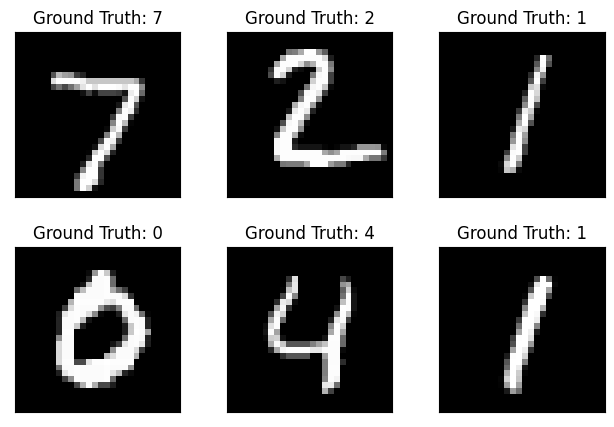

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
 
 
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
 
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [5]:
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1),nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2),nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
        
 
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [6]:
#检测是否有可用的GPU，有则使用，否则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#实例化网络
model = Net(28 * 28, 300, 100, 10)
model.to(device)
 
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [7]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []
 
 
for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    #动态修改参数学习率
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.1
    for img, label in train_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader), 
                     eval_loss / len(test_loader), eval_acc / len(test_loader)))

epoch: 0, Train Loss: 1.0149, Train Acc: 0.7857, Test Loss: 0.5312, Test Acc: 0.9027
epoch: 1, Train Loss: 0.4713, Train Acc: 0.9035, Test Loss: 0.3429, Test Acc: 0.9284
epoch: 2, Train Loss: 0.3424, Train Acc: 0.9212, Test Loss: 0.2682, Test Acc: 0.9389
epoch: 3, Train Loss: 0.2782, Train Acc: 0.9335, Test Loss: 0.2217, Test Acc: 0.9468
epoch: 4, Train Loss: 0.2374, Train Acc: 0.9419, Test Loss: 0.1912, Test Acc: 0.9522
epoch: 5, Train Loss: 0.2175, Train Acc: 0.9469, Test Loss: 0.1903, Test Acc: 0.9519
epoch: 6, Train Loss: 0.2156, Train Acc: 0.9474, Test Loss: 0.1890, Test Acc: 0.9522
epoch: 7, Train Loss: 0.2120, Train Acc: 0.9479, Test Loss: 0.1854, Test Acc: 0.9534
epoch: 8, Train Loss: 0.2092, Train Acc: 0.9494, Test Loss: 0.1837, Test Acc: 0.9536
epoch: 9, Train Loss: 0.2073, Train Acc: 0.9489, Test Loss: 0.1793, Test Acc: 0.9557
epoch: 10, Train Loss: 0.2061, Train Acc: 0.9499, Test Loss: 0.1803, Test Acc: 0.9550
epoch: 11, Train Loss: 0.2064, Train Acc: 0.9493, Test Loss: 0.1

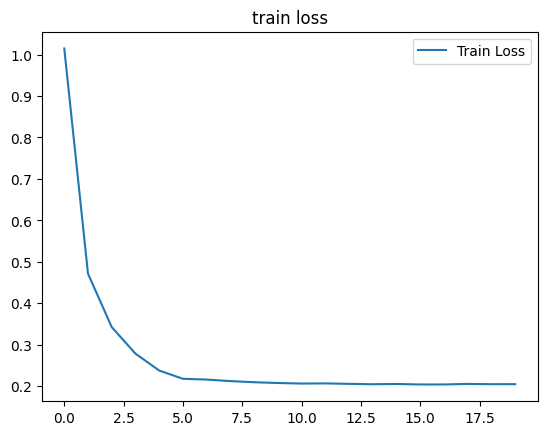

In [8]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
plt.legend(['Train Loss'], loc='upper right')

In [ ]:
# class Net(torch.nn.Module):
#     def __init__(self):
#         super(Net4, self).__init__()
#         self.conv = torch.nn.Sequential(
#             OrderedDict(
#                 [
#                     ("conv1", torch.nn.Conv2d(3, 32, 3, 1, 1)),
#                     ("relu1", torch.nn.ReLU()),
#                     ("pool", torch.nn.MaxPool2d(2))
#                 ]
#             ))
#  
#         self.dense = torch.nn.Sequential(
#             OrderedDict([
#                 ("dense1", torch.nn.Linear(32 * 3 * 3, 128)),
#                 ("relu2", torch.nn.ReLU()),
#                 ("dense2", torch.nn.Linear(128, 10))
#             ])
#         )

In [ ]:
# import torch.optim as optim
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [ ]:
# out = model(img)
# loss = criterion(out, label)

In [ ]:
# optimizer.zero_grad()

In [ ]:
# loss.backward()

In [ ]:
# optimizer.step()

In [ ]:
# len(optimizer.param_groups[0])#结果为6

In [ ]:
# for epoch in range(num_epoches):
#     动态修改参数学习率
    # if epoch%5==0:
    #     optimizer.param_groups[0]['lr']*=0.1
    #     print(optimizer.param_groups[0]['lr'])
    # for img, label in train_loader:
       #####

In [9]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
 
 
# 超参数
LR = 0.01
BATCH_SIZE = 32
EPOCH = 12

In [10]:
# 生成训练数据
# torch.unsqueeze() 的作用是将一维变二维，torch只能处理二维的数据
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)  
# 0.1 * torch.normal(x.size())增加噪点
y = x.pow(2) + 0.1 * torch.normal(torch.zeros(*x.size()))
 
torch_dataset = Data.TensorDataset(x,y)
#得到一个代批量的生成器
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [11]:
class Net(torch.nn.Module):
    # 初始化
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)
        self.predict = torch.nn.Linear(20, 1)
 
    # 前向传递
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

In [12]:
net_SGD = Net()
net_Momentum = Net()
net_RMSProp = Net()
net_Adam = Net()
 
nets = [net_SGD, net_Momentum, net_RMSProp, net_Adam]
 
opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.9)
opt_RMSProp = torch.optim.RMSprop(net_RMSProp.parameters(), lr=LR, alpha=0.9)
opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSProp, opt_Adam]

In [13]:
loss_func = torch.nn.MSELoss() 
loss_his = [[], [], [], []]  # 记录损失 
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, opt,l_his in zip(nets, optimizers, loss_his):
            output = net(batch_x)  # get output for every net
            loss = loss_func(output, batch_y)  # compute loss for every net
            opt.zero_grad()  # clear gradients for next train
            loss.backward()  # backpropagation, compute gradients
            opt.step()  # apply gradients
            l_his.append(loss.data.numpy())  # loss recoder
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']

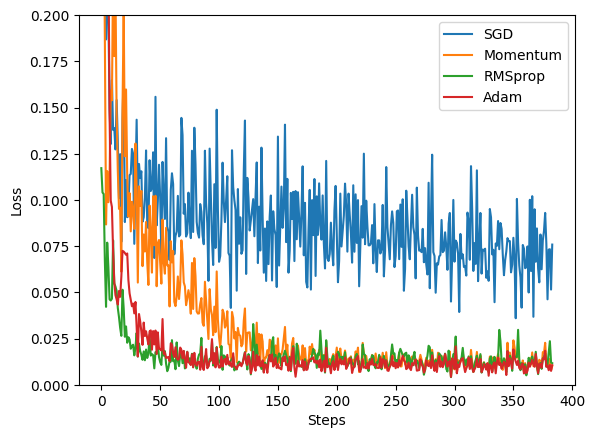

In [14]:
for i, l_his in enumerate(loss_his):
    plt.plot(l_his, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 0.2))
plt.show()

In [ ]:
# import torch
# import pandas as pd
# 
# # 假设你的模型是一个名为 model 的 PyTorch 模型
# # 假设你的数据集是一个名为 dataset 的可迭代对象，每个样本是一个元组 (id, data)
# 
# # 准备存储预测结果的列表
# predictions = []
# 
# # 循环遍历数据集进行预测
# for id, data in dataset:
#     # 假设你的模型接受一个张量作为输入，这里需要根据你的模型的输入格式进行相应的处理
#     input_tensor = torch.tensor(data)
#     
#     # 使用模型进行预测
#     output = model(input_tensor)
#     
#     # 假设模型的输出是一个张量，这里假设你的模型输出是单一值，如果不是，请根据实际情况修改
#     prediction = output.item()
#     
#     # 将预测结果和对应的 ID 存储到列表中
#     predictions.append((id, prediction))
# 
# # 将预测结果列表转换为 DataFrame
# df = pd.DataFrame(predictions, columns=['ID', 'Label'])
# 
# # 将 DataFrame 写入 CSV 文件
# df.to_csv('predictions.csv', index=False)
